# Convolutional autoencoder for classification Path Camelyon images 


In [14]:
# Tensorflow 
import tensorflow_datasets as tfds 
import tensorflow as tf 

# Additional
from matplotlib import pyplot as plt 
import numpy as np
from sklearn.metrics import mean_squared_error


**Load data**

50% of all three splits of PCAM-data is loaded. Where $D_1$ in used for training, $D_2$ for validation and $D_3$ for testing. Training data is divided in to two distinct subsets, i.e. $D_{1,a} \subset D_1$ and $D_{1,b} \subset D_1$ where $D_{1,a} \cap D_{1,b} = \emptyset$. $D_{1,a}$ is used to train the autoencoder that will compress images prior to classification. $D_{1,b}$ is used to train the classification model. $D_2$ and $D_3$ are divided in a similar fashion. 

In [3]:
d1, d2, d3 = tfds.load('patch_camelyon', split=[f'train[:50%]',f'test[:50%]',f'validation[:50%]'],
                          data_dir='./Data/PCAM', 
                          download=False, 
                          shuffle_files=True)

# Training data
d1_a, d1_b = d1.take(len(d1)//2), d1.skip(len(d1)//2)

# Test data 
d2_a, d2_b = d2.take(len(d2)//2), d2.skip(len(d2)//2)

# Valditation data 
d3_a, d3_b = d3.take(len(d3)//2), d3.skip(len(d3)//2)

print(f'Size of d1_a: {len(d1_a)} - size of d1_b: {len(d1_b)}')
print(f'Size of d2_a: {len(d2_a)} - size of d2_b: {len(d2_b)}')
print(f'Size of d3_a: {len(d3_a)} - size of d3_b: {len(d3_b)}')

Size of d1_a: 65536 - size of d1_b: 65536
Size of d2_a: 8192 - size of d2_b: 8192
Size of d3_a: 8192 - size of d3_b: 8192


In [4]:
def convert_sample(sample):
    image, label = sample['image'], sample['label']
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

d1_a, d1_b = d1_a.map(convert_sample).batch(32), d1_b.map(convert_sample).batch(32)
d2_a, d2_b = d2_a.map(convert_sample).batch(32), d2_b.map(convert_sample).batch(32)
d3_a, d3_b = d3_a.map(convert_sample).batch(32), d3_b.map(convert_sample).batch(32)

**Build autoencoder**

The autoencoder compress orginal images from a $(96,96,3)$ to a $(24,24,8)$ tensor. 

In [5]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,kernel_size=(3, 3),activation='relu',padding='same',strides=2,input_shape=(96, 96, 3)), 
    tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', strides=2),
],name='encoder')

decoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2DTranspose(8,3,strides=2,activation='relu',padding='same',input_shape=(24, 24, 8)),
    tf.keras.layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same'),
],name='decoder')

autoencoder = tf.keras.models.Sequential([encoder, decoder], name='autoencoder')

autoencoder.compile(loss='mse', optimizer='adam')

**Train autoencoder**

In [7]:
autoencoder.fit(d1_a.map(lambda x, y: (x,x)),
                 validation_data=d3_a.map(lambda x, y: (x,x)),
                 epochs=2)

Epoch 1/2
2048/2048 [==============================] - 117s 57ms/step - loss: 0.0134 - val_loss: 0.0079
Epoch 2/2
2048/2048 [==============================] - 132s 64ms/step - loss: 0.0070 - val_loss: 0.0066


**Save encoder + decoder weights for later use**

In [8]:
encoder.save_weights('/Users/augustwennerwald/Desktop/Anvendt Maskinlæring (DS807)/Exam/Saved_weights_prototypes/ae_encoder_weights_170124.h5')
decoder.save_weights('/Users/augustwennerwald/Desktop/Anvendt Maskinlæring (DS807)/Exam/Saved_weights_prototypes/ae_decoder_weights_170124.h5')

**Inspect reconstructions**

In [32]:
# Find a way to show loss based on prediction
test_set_reconstructions = autoencoder.predict(d2_a)

256/256 [==============================] - 4s 15ms/step


1/1 [==============================] - 0s 11ms/step


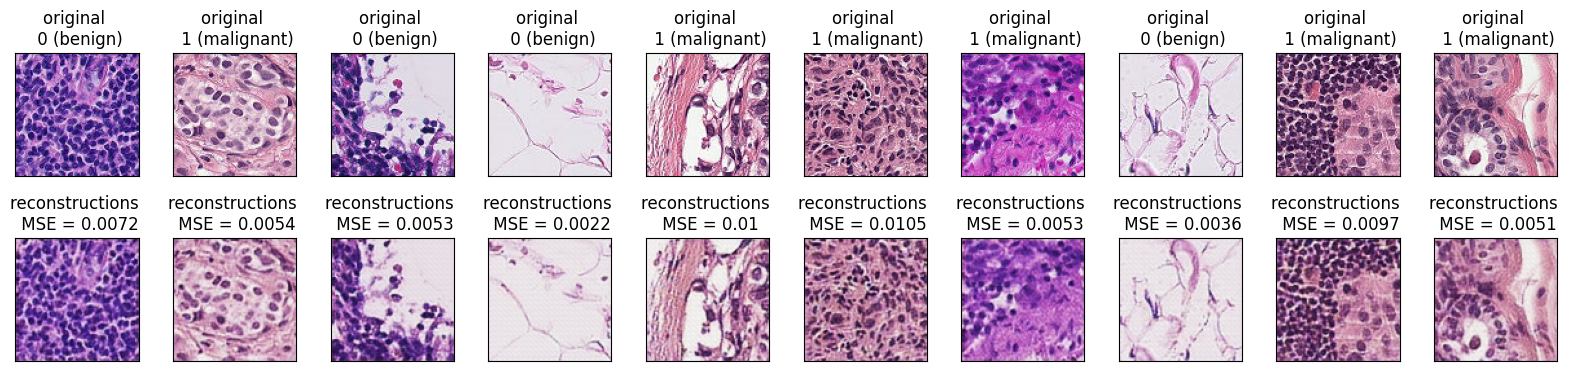

In [40]:
# Modified version of Christians plot() function. 
# This one samples a random img from the test set (d2_a)
# and encodes + decodes in runtime using the trained autoencoder

def plot_reconstructions(n): 
    
    class_label_dict = {0: 'benign', 1: 'malignant'}
    plt.figure(figsize=(20,4))
    batch = next(iter(d2_a))
     
    for i in range(n):
        original_img = batch[0][i].numpy()
        class_label_int = tf.argmax(batch[1][i]).numpy()
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_img)
        plt.title(f'original \n {class_label_int} ({class_label_dict[class_label_int]})')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        original_img_reshaped = original_img.reshape((1,)+original_img.shape)
        reconstructed_img = autoencoder.predict(original_img_reshaped)
        reconstructed_img_reshaped = np.reshape(reconstructed_img, (96,96,3))
        mse = round(tf.keras.losses.MeanSquaredError()(original_img, reconstructed_img_reshaped).numpy(),4)
        mse = str(mse)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_img_reshaped)
        plt.title("reconstructed")
        plt.title(f'reconstructions \n MSE = {mse}')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.subplots_adjust(hspace=0.5, wspace=0.2)
    plt.show()

plot_reconstructions(10) 

**Combine autoencoder with classification model**


In [41]:
# Recreate encoder and load + freeze weights 

classification_encoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,kernel_size=(3, 3),activation='relu',padding='same',strides=2,input_shape=(96, 96, 3)), 
    tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu', padding='same', strides=2),
],name='classification_encoder')

classification_encoder.load_weights('./Saved_weights_prototypes/ae_encoder_weights_170124.h5')

for layer in encoder.layers:
    layer.trainable = False

In [43]:
CNN_ae = tf.keras.models.Sequential([
    classification_encoder, 
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'),
], name = 'CNN_ae')

CNN_ae.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

CNN_ae.summary()

Model: "CNN_ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_encoder (Se  (None, 24, 24, 8)         1608      
 quential)                                                       
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                294976    
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 296714 (1.13 MB)
Trainable params: 296714 (1.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Train classification model**

In [44]:
CNN_ae.fit(d1_b, epochs=10)

Epoch 1/10
2048/2048 [==============================] - 27s 10ms/step - loss: 0.5557 - accuracy: 0.7425
Epoch 2/10
2048/2048 [==============================] - 26s 10ms/step - loss: 0.4806 - accuracy: 0.7760
Epoch 3/10
2048/2048 [==============================] - 27s 11ms/step - loss: 0.4554 - accuracy: 0.7900
Epoch 4/10
2048/2048 [==============================] - 27s 11ms/step - loss: 0.4343 - accuracy: 0.8040
Epoch 5/10
2048/2048 [==============================] - 28s 11ms/step - loss: 0.4112 - accuracy: 0.8161
Epoch 6/10
2048/2048 [==============================] - 28s 11ms/step - loss: 0.3896 - accuracy: 0.8305
Epoch 7/10
2048/2048 [==============================] - 28s 11ms/step - loss: 0.3640 - accuracy: 0.8428
Epoch 8/10
2048/2048 [==============================] - 28s 11ms/step - loss: 0.3452 - accuracy: 0.8530
Epoch 9/10
2048/2048 [==============================] - 28s 11ms/step - loss: 0.3202 - accuracy: 0.8645
Epoch 10/10
2048/2048 [==============================] - 29s 11m

In [45]:
# Save classification weights
CNN_ae.save_weights('./Saved_weights_prototypes/CNN_ae_weights.h5')

In [46]:
CNN_ae.predict(d3_b)

256/256 [==============================] - 2s 5ms/step


array([[9.6507573e-01, 3.4924272e-02],
       [8.0764538e-01, 1.9235460e-01],
       [7.3362994e-01, 2.6637006e-01],
       ...,
       [9.9989259e-01, 1.0742063e-04],
       [9.9450511e-01, 5.4948241e-03],
       [3.8409799e-01, 6.1590195e-01]], dtype=float32)